In [ ]:
!pip install pandas_datareader
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas_datareader.data as web
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf

In [2]:
data = web.DataReader('^DJI', data_source = 'yahoo', start = '2000-01-01')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5245 entries, 2000-01-03 to 2020-11-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       5245 non-null   float64
 1   Low        5245 non-null   float64
 2   Open       5245 non-null   float64
 3   Close      5245 non-null   float64
 4   Volume     5245 non-null   int64  
 5   Adj Close  5245 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 286.8 KB


In [4]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,11522.009766,11305.690430,11501.849609,11357.509766,169750000,11357.509766
2000-01-04,11350.059570,10986.450195,11349.750000,10997.929688,178420000,10997.929688
2000-01-05,11215.099609,10938.669922,10989.370117,11122.650391,203190000,11122.650391
2000-01-06,11313.450195,11098.450195,11113.370117,11253.259766,176550000,11253.259766
2000-01-07,11528.139648,11239.919922,11247.059570,11522.559570,184900000,11522.559570


In [5]:
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-10-29,26891.890625,26290.779297,26480.980469,26659.109375,419770000,26659.109375
2020-10-30,26639.179688,26143.769531,26572.269531,26501.599609,504820000,26501.599609
2020-11-02,27043.480469,26691.279297,26691.279297,26925.050781,379990000,26925.050781
2020-11-03,27640.210938,27138.689453,27138.689453,27480.029297,350980000,27480.029297
2020-11-04,28301.500000,27512.830078,27512.830078,27847.660156,449894278,27847.660156


In [6]:
data.reset_index(inplace = True)

In [7]:
data.head(4)

,Date,High,Low,Open,Close,Volume,Adj Close
0,2000-01-03,11522.009766,11305.690430,11501.849609,11357.509766,169750000,11357.509766
1,2000-01-04,11350.059570,10986.450195,11349.750000,10997.929688,178420000,10997.929688
2,2000-01-05,11215.099609,10938.669922,10989.370117,11122.650391,203190000,11122.650391
3,2000-01-06,11313.450195,11098.450195,11113.370117,11253.259766,176550000,11253.259766


In [ ]:
data.isnull().sum()

Date         0
High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [ ]:
data.shape

(5245, 7)

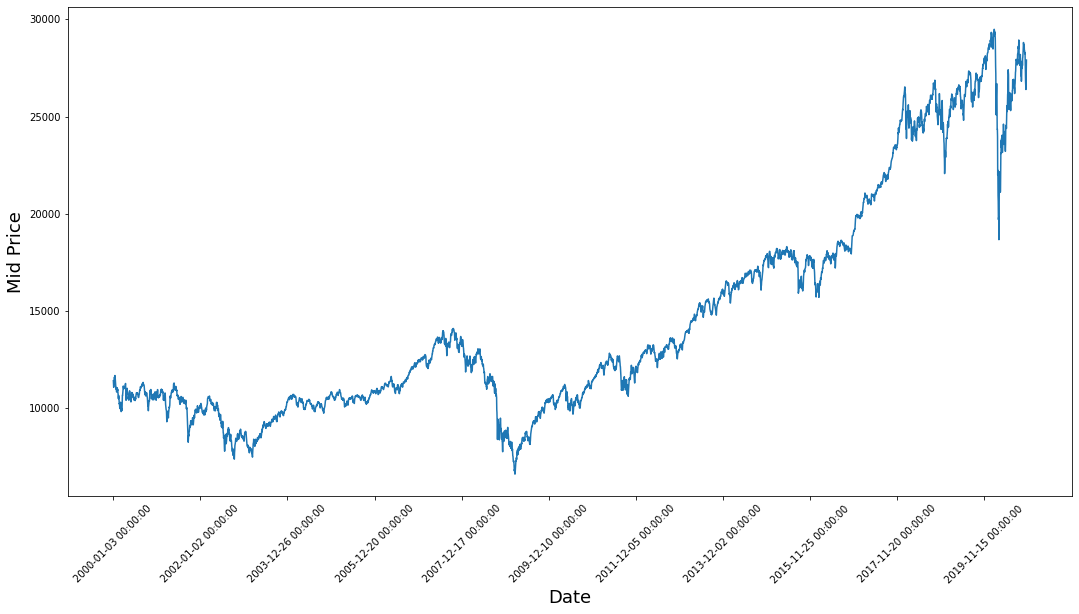

In [8]:
plt.figure(figsize = (18,9))
plt.plot(range(data.shape[0]),(data['Low']+data['High'])/2.0)
plt.xticks(range(0,data.shape[0],500),data['Date'].loc[::500],rotation = 45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

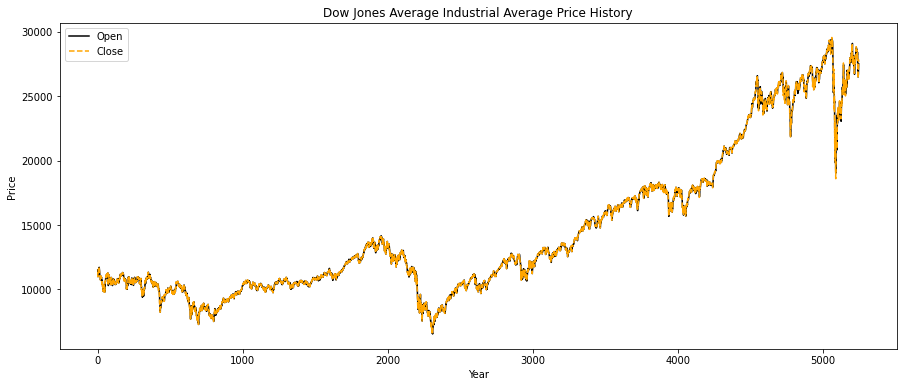

In [9]:
plt.figure(figsize=(15,6))
plt.plot(data['Open'], color = 'black')
plt.plot(data['Close'], color = 'orange', linestyle = 'dashed')
plt.title('Dow Jones Average Industrial Average Price History')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(['Open', 'Close'], loc ='best')

In [10]:
#Normalize the data
train_split = int(0.8 * len(data))
test_split = len(data) - train_split

training_set = data.iloc[:train_split, 1:]
test_set = data.iloc[train_split:len(data), 1:]

In [11]:
print("Train data shape:",training_set.shape)
print("Test data shape:",test_set.shape)

Train data shape: (4196, 6)
Test data shape: (1049, 6)


In [12]:
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled = sc.transform(test_set)

In [13]:
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i,4])
    y_train.append(training_set_scaled[i,4])

X_train, y_train = np.array(X_train), np.array(y_train)

In [14]:
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)

X_train shape: (4136, 60)
y_train shape: (4136,)


In [15]:
last_60_days = training_set.tail(60)
df_test = last_60_days.append(test_set)
df_test.head()

,High,Low,Open,Close,Volume,Adj Close
4136,17893.279297,17731.349609,17830.500000,17732.480469,101690000,17732.480469
4137,17733.919922,17595.789062,17710.769531,17674.820312,93740000,17674.820312
4138,17762.960938,17629.009766,17703.650391,17640.169922,94130000,17640.169922
4139,17754.910156,17471.289062,17602.230469,17733.099609,91950000,17733.099609
4140,17733.439453,17602.779297,17733.439453,17675.160156,248680000,17675.160156


In [16]:
input_test = sc.transform(df_test)
input_test.shape

(1109, 6)

In [17]:
X_test =[]
y_test =[]

for i in range(60,input_test.shape[0]):
    X_test.append(input_test[i-60:i,4])
    y_test.append(input_test[i,4])
    
X_test, y_test = np.array(X_test), np.array(y_test)
print(X_test.shape)
print(y_test.shape)

(1049, 60)
(1049,)


In [18]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_train.shape, X_test.shape

((4136, 60, 1), (1049, 60, 1))

In [19]:
model = Sequential()
model.add(LSTM(units = 80, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 80, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 80))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', 
              loss = 'mean_squared_error',
              metrics = ["MSE"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 80)            26240     
_________________________________________________________________
dropout (Dropout)            (None, 60, 80)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 80)            51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8

In [20]:
# Fitting the RNN to the Training set
history = model.fit(X_train, y_train, 
          epochs = 50, 
          validation_data=(X_test,y_test),
          batch_size = 32)

Epoch 1/50
130/130 [==============================] - 17s 127ms/step - loss: 0.0089 - MSE: 0.0089 - val_loss: 0.0221 - val_MSE: 0.0221
Epoch 2/50
130/130 [==============================] - 17s 127ms/step - loss: 0.0072 - MSE: 0.0072 - val_loss: 0.0210 - val_MSE: 0.0210
Epoch 3/50
130/130 [==============================] - 17s 131ms/step - loss: 0.0068 - MSE: 0.0068 - val_loss: 0.0201 - val_MSE: 0.0201
Epoch 4/50
130/130 [==============================] - 17s 132ms/step - loss: 0.0066 - MSE: 0.0066 - val_loss: 0.0197 - val_MSE: 0.0197
Epoch 5/50
130/130 [==============================] - 20s 154ms/step - loss: 0.0067 - MSE: 0.0067 - val_loss: 0.0239 - val_MSE: 0.0239
Epoch 6/50
130/130 [==============================] - 17s 131ms/step - loss: 0.0064 - MSE: 0.0064 - val_loss: 0.0196 - val_MSE: 0.0196
Epoch 7/50
130/130 [==============================] - 17s 132ms/step - loss: 0.0063 - MSE: 0.0063 - val_loss: 0.0185 - val_MSE: 0.0185
Epoch 8/50
130/130 [==============================] - 1

In [21]:
### Making predictions on x_test dataset
y_pred = model.predict(X_test, verbose = True)

33/33 [==============================] - 1s 30ms/step


In [22]:
y_pred.shape

(1049, 1)

In [23]:
rmse = np.mean((y_pred - y_test)**2)
print('Mean Squared Error for predictions is',rmse)  

Mean Squared Error for predictions is 0.051840031264247806


In [24]:
scale_vale = sc.scale_
y_pred = y_pred * (1/scale_vale[4])
y_test = y_test * (1/scale_vale[4])

In [25]:
scale_vale

array([8.32431566e-05, 8.27131262e-05, 8.28674065e-05, 8.27198213e-05,
       1.36980672e-09, 8.27198213e-05])

In [26]:
y_pred.shape

(1049, 1)

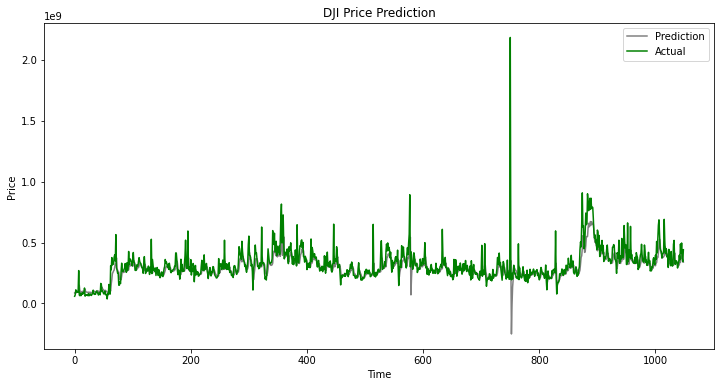

In [27]:
plt.figure(figsize=(12,6))
plt.plot(y_pred, color = 'grey', label = 'Predicted Values')
plt.plot(y_test, color = 'green', label = 'Actual DJI Values')
plt.title('DJI Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(['Prediction', 'Actual'], loc ='best')

In [28]:
future_input = test_set[989:]
future_input.head()

,High,Low,Open,Close,Volume,Adj Close
5185,28043.890625,27843.320312,27860.240234,27976.839844,340210000,27976.839844
5186,27986.099609,27789.779297,27922.509766,27896.720703,360160000,27896.720703
5187,27977.810547,27759.390625,27828.929688,27931.019531,275540000,27931.019531
5188,27999.810547,27816.400391,27970.050781,27844.910156,286860000,27844.910156
5189,27891.119141,27668.789062,27853.480469,27778.070312,276170000,27778.070312


In [29]:
future_input.tail()

,High,Low,Open,Close,Volume,Adj Close
5240,26891.890625,26290.779297,26480.980469,26659.109375,419770000,26659.109375
5241,26639.179688,26143.769531,26572.269531,26501.599609,504820000,26501.599609
5242,27043.480469,26691.279297,26691.279297,26925.050781,379990000,26925.050781
5243,27640.210938,27138.689453,27138.689453,27480.029297,350980000,27480.029297
5244,28301.500000,27512.830078,27512.830078,27847.660156,449894278,27847.660156


In [30]:
future_input.shape
x_input = future_input["Close"].values

In [31]:
#temp_future = future_input["Close"].values
temp_future = x_input.tolist()
len(temp_future)

60

In [32]:
temp_future

[27976.83984375,
 27896.720703125,
 27931.01953125,
 27844.91015625,
 27778.0703125,
 27692.880859375,
 27739.73046875,
 27930.330078125,
 28308.4609375,
 28248.439453125,
 28331.919921875,
 28492.26953125,
 28653.869140625,
 28430.05078125,
 28645.66015625,
 29100.5,
 28292.73046875,
 28133.310546875,
 27500.890625,
 27940.470703125,
 27534.580078125,
 27665.640625,
 27993.330078125,
 27995.599609375,
 28032.380859375,
 27901.98046875,
 27657.419921875,
 27147.69921875,
 27288.1796875,
 26763.130859375,
 26815.439453125,
 27173.9609375,
 27584.060546875,
 27452.66015625,
 27781.69921875,
 27816.900390625,
 27682.810546875,
 28148.640625,
 27772.759765625,
 28303.4609375,
 28425.509765625,
 28586.900390625,
 28837.51953125,
 28679.810546875,
 28514.0,
 28494.19921875,
 28606.310546875,
 28195.419921875,
 28308.7890625,
 28210.8203125,
 28363.66015625,
 28335.5703125,
 27685.380859375,
 27463.189453125,
 26519.94921875,
 26659.109375,
 26501.599609375,
 26925.05078125,
 27480.029296875,

In [33]:
from numpy import array

lstm_output=[]
n_steps = 60
i = 1
while i < 6:
    
    if(len(temp_future) > 60):
        #print(temp_input)
        x_input = np.array(temp_future[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_future.extend(yhat[0].tolist())
        temp_future = temp_future[1:]
        #print(temp_input)
        lstm_output.extend(yhat.tolist())
        i = i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_future.extend(yhat[0].tolist())
        print(len(temp_future))
        lstm_output.extend(yhat.tolist())
        i = i+1
    

print(lstm_output)



[0.37343976]
61
2 day input [2.78967207e+04 2.79310195e+04 2.78449102e+04 2.77780703e+04
 2.76928809e+04 2.77397305e+04 2.79303301e+04 2.83084609e+04
 2.82484395e+04 2.83319199e+04 2.84922695e+04 2.86538691e+04
 2.84300508e+04 2.86456602e+04 2.91005000e+04 2.82927305e+04
 2.81333105e+04 2.75008906e+04 2.79404707e+04 2.75345801e+04
 2.76656406e+04 2.79933301e+04 2.79955996e+04 2.80323809e+04
 2.79019805e+04 2.76574199e+04 2.71476992e+04 2.72881797e+04
 2.67631309e+04 2.68154395e+04 2.71739609e+04 2.75840605e+04
 2.74526602e+04 2.77816992e+04 2.78169004e+04 2.76828105e+04
 2.81486406e+04 2.77727598e+04 2.83034609e+04 2.84255098e+04
 2.85869004e+04 2.88375195e+04 2.86798105e+04 2.85140000e+04
 2.84941992e+04 2.86063105e+04 2.81954199e+04 2.83087891e+04
 2.82108203e+04 2.83636602e+04 2.83355703e+04 2.76853809e+04
 2.74631895e+04 2.65199492e+04 2.66591094e+04 2.65015996e+04
 2.69250508e+04 2.74800293e+04 2.78476602e+04 3.73439759e-01]
2 day output [[0.45289496]]
3 day input [2.79310195e+04 

In [34]:
day_new = np.arange(1,61)
day_pred = np.arange(61,66)

In [35]:
y_test.shape

(1049,)

In [37]:
lstm_output = np.array(lstm_output) * (1/scale_vale[4])
lstm_output

array([[2.72622227e+08],
       [3.30626905e+08],
       [3.54138533e+08],
       [3.76131312e+08],
       [3.94544044e+08]])

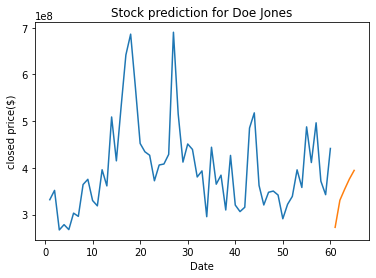

In [39]:
plt.plot(day_new,y_test[989:])
plt.plot(day_pred, lstm_output)
plt.title('Stock prediction for Doe Jones')
plt.xlabel("Date")
plt.ylabel("closed price($)")
plt.show()
